# Seq2Seq 한계
- Seq2Seq 모델은 번역(translation), 챗봇 등의 task에서 높은 성능을 보임
- 하지만 Seq2Seq 모델은 커다란 한계가 있음.
- 입력 시퀸스의 모든 정보를 하나의 고정된 크기의 벡터(컨텍스트 벡터)에 다 압축 요약하려 하다 보니 정보의 손실이 생길 수밖에 없음
- 특히 시퀸스의 길이가 길다면 정보의 손실이 더 커짐
- 대안으로 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위해 어텐션(attention) 기법이 등장

# 주의 메커니즘(Attention Mechanism)
- Seq2Seq 모델의 문제점을 개선하기 위해 제안
- 인코더에서 필요한 정보를 디코더로 가져오는 방법

## Attention 동작 방법
- Attention(Q, K, V) = Attention Value
    - Q(Query) : 디코더의 t 시점 셀의 hidden state
    - K(Keys) : 인코더의 모든 시점 셀의 hidden state
    - V(Values) : 인코더 모든 시점 셀의 hidden state


## 매우 중요!

In [8]:
import numpy as np

# 토큰화된 문장 (인코더의 입력)
tokens = ["저는", "지금부터", "어텐션을", "공부합니다", "."]
deco_input = ['i', 'now', 'study', 'attention']

# 인코더의 임베딩 벡터 (5개의 단어를 4차원 벡터로 표현한 예시)
embeddings = np.array([
    [0.1, 0.2, 0.3, 0.4],   # "저는"
    [0.5, 0.6, 0.7, 0.8],   # "지금부터"
    [0.9, 1.0, 1.1, 1.2],   # "어텐션을"
    [1.3, 1.4, 1.5, 1.6],   # "공부합니다"
    [0.0, 0.0, 0.0, 0.0]    # "."
])

# 디코더의 첫 번째 단어의 임베딩 벡터 (예시로 "i"에 해당하는 벡터를 사용)
decoder_first_input = np.array([1.0, 0.9, 0.8, 0.7])  # "i"

# 쿼리: 디코더의 첫 번째 단어 벡터
query = decoder_first_input.reshape(1, -1)  # (1, 4)

# 키: 인코더에서 나온 모든 히든 스테이트 (즉, 임베딩 벡터)
key = embeddings  # (5, 4)

# 값: 인코더의 모든 히든 스테이트 (임베딩 벡터와 동일)
value = embeddings  # (5, 4)

# 어텐션 스코어 (쿼리와 키의 내적을 통해 구함)
attention_scores = np.dot(query, key.T)  # (1, 5)

# 어텐션 가중치 (Softmax 적용)
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

attention_weights = softmax(attention_scores)  # (1, 5)

# 가중치를 값에 곱하여 최종 어텐션 결과를 구함
attention_output = np.dot(attention_weights, value)  # (1, 4)

# 출력 결과
print("어텐션 스코어:\n", attention_scores)
print("\n어텐션 가중치:\n", attention_weights)
print("\n어텐션 결과:\n", attention_output)


어텐션 스코어:
 [[0.8  2.16 3.52 4.88 0.  ]]

어텐션 가중치:
 [[0.01255157 0.04890334 0.19053686 0.74236845 0.00563978]]

어텐션 결과:
 [[1.16226898 1.261705   1.36114103 1.46057705]]


1. 어텐션 스코어(유사도)를 구함
    - 디코더의 t 시점 셀의 hidden state(Query) 와 인코더의 모든 시점 셀의 hidden state(Keys)를 내적(Dot product)하여 유사도를 구한다.

$$
e^{t}=[s_{t}^Th_{1},...,s_{t}^Th_{N}]
$$


2. 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구함
    - 소프트맥스를 이용하여 어텐션 스코어의 확률 분포를 구한다.

$$
α^{t} = softmax(e^{t})
$$


3. 인코더 각 시점의 어텐션 분포(가중치)와 인코더 모든 시점 셀의 hidden state(Values) 가중합하여 어텐션 값(Attention Value)을 구함
    - 인코더 모든 시점 셀의 hidden state와 어텐션 분포인 가중치들을 곱하고 합하여 어텐션 값을 구한다.

$$
a_{v}=\sum_{i=1}^{N} α_{i}^{t}h_{i}
$$


4. 어텐션 값과 디코더 t시점의 hidden state 를 연결(Concatenate)
    - 연결한 텐서를 Fully Connected Layer 에 전달하여 단어를 예측

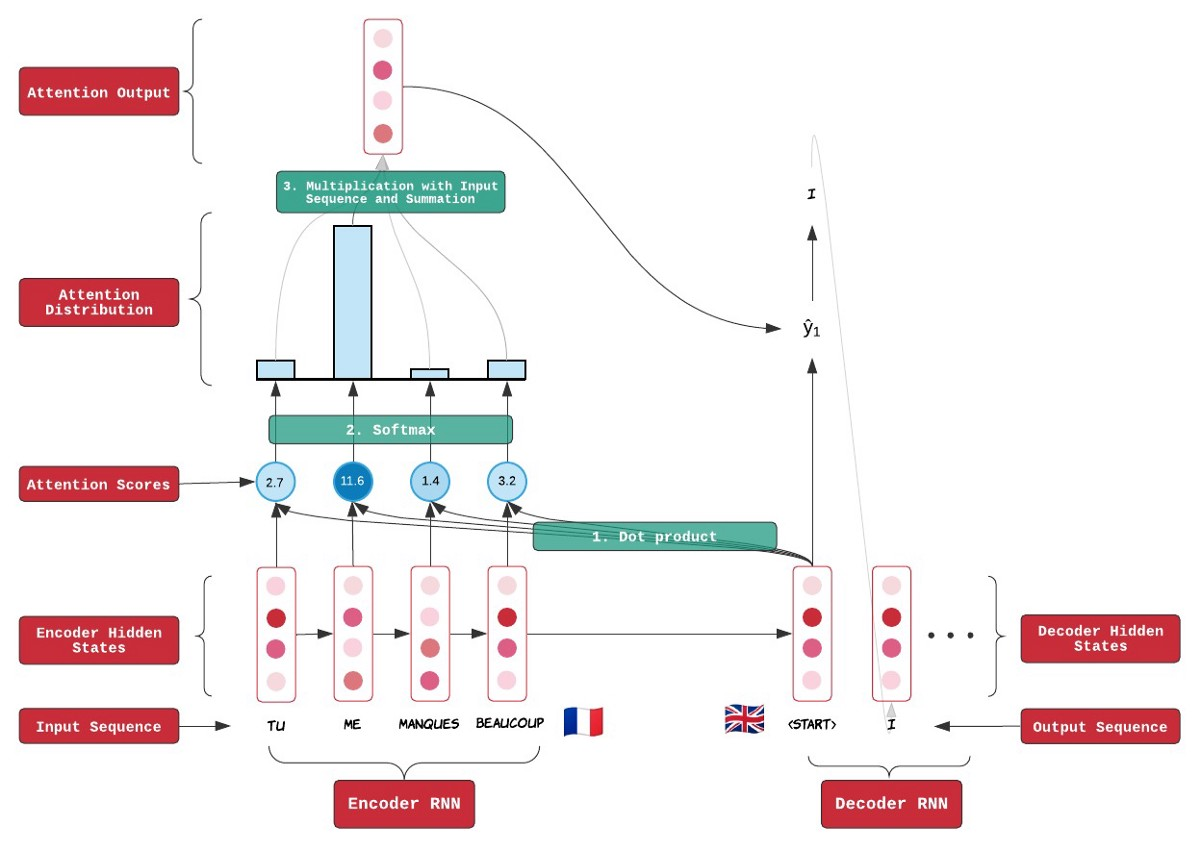

* Attention의 원리
    - 키(Key)와 값(Value): 인코더의 각 출력에서 추출된 정보입니다. 키는 인코더의 각 단어의 "특징"을 나타내고, 값은 그 단어의 정보를 포함한 표현입니다.

    - 쿼리(Query): 디코더의 출력에서 추출된 정보로, 현재 예측하고 있는 단어와 관련된 정보를 찾기 위해 사용됩니다.

    - 유사도 계산: 디코더의 쿼리와 인코더의 키 사이의 유사도를 계산합니다. 이는 주로 쿼리 * 키^T 형태로 계산되며, 그 결과는 각 인코더 단어와 현재 디코더 단어의 연관성 정도를 나타냅니다.

    - 소프트맥스(Softmax): 유사도를 소프트맥스로 정규화하여 각 인코더 단어에 대한 가중치를 계산합니다. 이 가중치는 디코더가 어떤 인코더 단어에 더 집중해야 하는지를 나타냅니다.

    - 가중합: 각 인코더 단어의 값(Value)에 가중치를 곱해 가중합을 구합니다. 이 가중합 결과가 디코더에게 전달되어, 예측에 필요한 중요한 정보로 사용됩니다.

    - 디코더에 결합: 이 Attention 결과를 디코더의 입력과 합치거나 곱하여 디코더가 다음 예측에 활용할 수 있도록 합니다.

In [6]:
!pip install kiwipiepy

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

DATA_PATH = "/content/drive/MyDrive/04_nlp/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_PATH=os.getcwd()+'/data/en2ko/'
train = pd.read_csv(f"{DATA_PATH}translate_en_ko.csv")
train[['ko','en']]

,ko,en
0,이 제품들은 같은 품질이다.,These products are of the same quality.
1,미팅이 취소되었다.,The meeting was cancelled.
2,그들이 이것을 찾았다.,They found this.
3,톰은 메리에게 왜 그가 늦게까지 일해야 했는지 알려주지 않았다.,Tom didn't tell Mary why he had to work late.
4,먼저 가세요.,After you.
...,...,...
5789,일할 준비 됐니?,Are you ready to start working?
5790,"번거롭게 해 드려 죄송하지만, 저 좀 도와주시겠어요?","Sorry to trouble you, but can you help me?"
5791,방금 말씀하신 것을 다시 한번 말씀해 주시겠어요?,Could you please repeat what you just said?
5792,탐은 해양 생물학자가 되기 위해 공부하고 있다.,Tom is studying to become a marine biologist.


In [4]:
train["ko"] = train["ko"].str.replace("[^가-힣 0-9,.!?\"\']","", regex=True)
train["en"] = train["en"].str.replace("[^a-zA-Z 0-9,.!?\"\']","", regex=True).str.lower()

In [5]:
from kiwipiepy import Kiwi

kiwi = Kiwi()

In [6]:
result = kiwi.tokenize(train["ko"])
ko_src_data = []
for tokens in tqdm(result):
    tokens = [ t.form for t in tokens]
    ko_src_data.append(tokens)

print(ko_src_data[0])
print('=========')
print(ko_src_data)

0it [00:00, ?it/s]

['이', '제품', '들', '은', '같', '은', '품질', '이', '다', '.']
[['이', '제품', '들', '은', '같', '은', '품질', '이', '다', '.'], ['미팅', '이', '취소', '되', '었', '다', '.'], ['그', '들', '이', '이것', '을', '찾', '었', '다', '.'], ['톰', '은', '메리', '에게', '왜', '그', '가', '늦', '게', '까지', '일', '하', '어야', '하', '었', '는지', '알리', '어', '주', '지', '않', '었', '다', '.'], ['먼저', '가', '세요', '.'], ['계속', '웃', '어', '.'], ['비', '가', '내리', '면', '집', '에', '있', '을', '것', '이', '다', '.'], ['나', '피', '나', '어'], ['톰', '이', '승낙', '하', '었', '어', '.'], ['방금', '나', 'ᆯ', '모욕', '하', '었', '어', '?'], ['나', 'ᆫ', '집중', '하', '려고', '애', '를', '쓰', '고', '있', '어', '.'], ['너', 'ᆫ', '왜', '그렇', '게', '바보', '같이', '굴', '어', '?'], ['끼', '어', '들', '어서', '죄송하', 'ᆸ니다', '.'], ['톰', '은', '기말', '시험', '공부', '를', '안', '하', '었', '어', '.'], ['그런', '일', '이', '생기', 'ᆫ다면', '어쩌', 'ᆯ', '거', '이', '야', '?'], ['톰', '은', '맥주', '를', '원', '하', 'ᆫ다', '.'], ['그거', 'ᆫ', '톰', '이', '이야기', '하', 'ᆫ', '것', '이', '아니', '다', '.'], ['메리', '는', '톰', '의', '자켓', '에서', '길', 'ᆫ', '금발', '머리카락', '한', '올', '을

In [7]:
ko_src_data[0],ko_src_data[10]

(['이', '제품', '들', '은', '같', '은', '품질', '이', '다', '.'],
 ['나', 'ᆫ', '집중', '하', '려고', '애', '를', '쓰', '고', '있', '어', '.'])

In [8]:
from torchtext.vocab import build_vocab_from_iterator
vocab_src = build_vocab_from_iterator(ko_src_data, specials=["<pad>", "<unk>"])
vocab_src.set_default_index(vocab_src["<unk>"])
len(vocab_src)

c:\Users\hopio\anaconda3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\hopio\anaconda3\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


3245

In [9]:
ko_src_data = [ vocab_src(tokens) for tokens in ko_src_data]
ko_src_data

[[4, 2926, 32, 8, 50, 8, 3151, 4, 9, 2],
 [1112, 4, 1254, 38, 6, 9, 2],
 [22, 32, 4, 87, 12, 209, 6, 9, 2],
 [10,
  8,
  49,
  46,
  84,
  22,
  13,
  212,
  41,
  229,
  58,
  5,
  48,
  5,
  6,
  102,
  371,
  3,
  34,
  21,
  28,
  6,
  9,
  2],
 [893, 13, 62, 2],
 [166, 163, 3, 2],
 [246, 13, 414, 134, 85, 18, 16, 12, 25, 4, 9, 2],
 [11, 380, 11, 3],
 [10, 4, 2561, 5, 6, 3, 2],
 [1498, 11, 17, 2279, 5, 6, 3, 15],
 [11, 14, 434, 5, 176, 237, 19, 97, 20, 16, 3, 2],
 [26, 14, 84, 115, 41, 679, 165, 440, 3, 15],
 [587, 3, 32, 82, 1231, 92, 2],
 [10, 8, 2023, 459, 125, 19, 56, 5, 6, 3, 2],
 [305, 58, 4, 609, 410, 786, 17, 27, 4, 23, 15],
 [10, 8, 451, 19, 464, 5, 31, 2],
 [75, 14, 10, 4, 334, 5, 14, 25, 4, 83, 9, 2],
 [49,
  7,
  10,
  24,
  1214,
  43,
  306,
  14,
  1362,
  1098,
  91,
  2708,
  12,
  1492,
  5,
  6,
  9,
  2],
 [10, 46, 29, 5, 3, 2],
 [509, 137, 3, 34, 3, 2],
 [4, 1758, 123, 141, 38, 54, 15],
 [11, 14, 210, 118, 13, 48, 5, 3, 2],
 [10, 8, 1784, 47, 4, 23, 2],
 [11, 1

In [10]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

c:\Users\hopio\anaconda3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [11]:
sos_token = "<sos>"
eos_token = "<eos>"

In [12]:
en_trg_data = []
for text in train["en"]:
    tokens = [sos_token] + tokenizer(text) + [eos_token]
    print(tokens)
    en_trg_data.append(tokens)
         

['<sos>', 'these', 'products', 'are', 'of', 'the', 'same', 'quality', '.', '<eos>']
['<sos>', 'the', 'meeting', 'was', 'cancelled', '.', '<eos>']
['<sos>', 'they', 'found', 'this', '.', '<eos>']
['<sos>', 'tom', 'didn', "'", 't', 'tell', 'mary', 'why', 'he', 'had', 'to', 'work', 'late', '.', '<eos>']
['<sos>', 'after', 'you', '.', '<eos>']
['<sos>', 'keep', 'smiling', '.', '<eos>']
['<sos>', 'if', 'it', 'rains', ',', 'i', "'", 'll', 'stay', 'at', 'home', '.', '<eos>']
['<sos>', 'i', "'", 'm', 'bleeding', '.', '<eos>']
['<sos>', 'tom', 'approved', '.', '<eos>']
['<sos>', 'did', 'you', 'just', 'insult', 'me', '?', '<eos>']
['<sos>', 'i', "'", 'm', 'having', 'a', 'hard', 'time', 'concentrating', '.', '<eos>']
['<sos>', 'why', 'are', 'you', 'acting', 'so', 'stupid', '?', '<eos>']
['<sos>', 'i', "'", 'm', 'sorry', 'for', 'interrupting', '.', '<eos>']
['<sos>', 'tom', 'didn', "'", 't', 'study', 'for', 'his', 'final', 'exam', '.', '<eos>']
['<sos>', 'what', 'would', 'you', 'do', 'if', 'that',

In [13]:
vocab_trg = build_vocab_from_iterator(en_trg_data, specials=["<pad>", "<unk>", sos_token, eos_token])
vocab_trg.set_default_index(vocab_trg["<unk>"])

In [14]:
len(vocab_trg)

3129

In [15]:
en_trg_data = [ vocab_trg(tokens) for tokens in en_trg_data ]

In [16]:
en_trg_data # 시작과 끝을 알리는 2,3이 각각 맨 끝에 붙어있음을 확인 할 수 있다.

[[2, 210, 2696, 29, 27, 11, 291, 1584, 4, 3],
 [2, 11, 574, 23, 1314, 4, 3],
 [2, 68, 477, 21, 4, 3],
 [2, 7, 56, 6, 14, 93, 43, 62, 22, 84, 9, 111, 165, 4, 3],
 [2, 242, 8, 4, 3],
 [2, 117, 586, 4, 3],
 [2, 79, 17, 1589, 20, 5, 6, 61, 188, 51, 97, 4, 3],
 [2, 5, 6, 25, 1909, 4, 3],
 [2, 7, 1818, 4, 3],
 [2, 57, 8, 120, 2384, 30, 10, 3],
 [2, 5, 6, 25, 258, 13, 124, 74, 713, 4, 3],
 [2, 62, 29, 8, 461, 101, 455, 10, 3],
 [2, 5, 6, 25, 112, 37, 1480, 4, 3],
 [2, 7, 56, 6, 14, 209, 37, 44, 876, 728, 4, 3],
 [2, 34, 85, 8, 18, 79, 15, 301, 9, 8, 10, 3],
 [2, 7, 184, 13, 464, 4, 3],
 [2, 15, 6, 16, 42, 34, 7, 12, 425, 80, 4, 3],
 [2, 43, 477, 13, 172, 1298, 480, 58, 7, 6, 16, 1119, 4, 3],
 [2, 93, 7, 4, 3],
 [2, 71, 217, 4, 3],
 [2, 32, 5, 24, 21, 849, 10, 3],
 [2, 5, 24, 9, 54, 185, 4, 3],
 [2, 7, 12, 1766, 4, 3],
 [2, 5, 6, 25, 64, 9, 54, 41, 55, 7, 4, 3],
 [2, 7, 88, 22, 167, 9, 54, 424, 4, 3],
 [2, 50, 1022, 118, 11, 448, 4, 3],
 [2, 99, 527, 4, 3],
 [2, 5, 150, 746, 122, 15, 4, 3],
 [

In [17]:
class TranslateDataset(torch.utils.data.Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg
    def __len__(self):
        return len(self.src)
    def __getitem__(self, idx):
        item = {}
        item["src"] = torch.tensor( self.src[idx] )
        item["trg"] = torch.tensor( self.trg[idx] )
        return item

In [18]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,src,trg):
        self.src=src
        self.trg=trg
    def __len__(self):
        return len(self.src)
    def __getitem__(self,idx):
        return {'src':torch.tensor(self.src[idx]),'trg':torch.tensor(self.trg[idx])}

In [19]:
import pprint as pp
from torch.nn.utils.rnn import pad_sequence
def collate_fn(lst):
    src = [ item["src"] for item in lst]
    src = pad_sequence(src, batch_first=True)

    trg = [ item["trg"] for item in lst]
    trg = pad_sequence(trg, batch_first=True)

    return {"src": src, "trg": trg}

In [20]:
dt = TranslateDataset(ko_src_data, en_trg_data)
dl = torch.utils.data.DataLoader(dt, 2 , shuffle=False, collate_fn= collate_fn)
batch = next(iter(dl))
batch

{'src': tensor([[   4, 2926,   32,    8,   50,    8, 3151,    4,    9,    2],
         [1112,    4, 1254,   38,    6,    9,    2,    0,    0,    0]]),
 'trg': tensor([[   2,  210, 2696,   29,   27,   11,  291, 1584,    4,    3],
         [   2,   11,  574,   23, 1314,    4,    3,    0,    0,    0]])}

# 인코더 레이어

In [21]:
class Encoder(torch.nn.Module):
    def __init__(self, vocab_size_src, embedding_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(vocab_size_src, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim * 2, batch_first=True, bidirectional=True)

        #  batch_first=True이 상당히 중요함, 
        # 한국어-영어 와 같이 어순이 반대인 경우 역방향 정보를 주면 잘 학습을 한다.
        
    def forward(self, src):
        x = self.emb_layer(src) # batch, seq -> batch, seq, features

        # outputs: batch, seq, features
        # hn 과 cn : nlayer, batch, features
        outputs, (hn, cn) = self.rnn_layer(x)
        hn=hn.permute(1,0,2).flatten(1).unsqueeze(0)
        cn=cn.permute(1,0,2).flatten(1).unsqueeze(0)

        # outputs을 이용하기 시작함
        return outputs, hn, cn

In [22]:
encoder = Encoder(len(vocab_src), 64)
outputs, hn, cn = encoder(batch["src"])
outputs.shape, hn.shape, cn.shape
#(torch.Size([2, 10, 256]), torch.Size([2, 2, 128]), torch.Size([2, 2, 128]))

(torch.Size([2, 10, 256]), torch.Size([1, 2, 256]), torch.Size([1, 2, 256]))

# 디코더 레이어

In [30]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size_trg, embedding_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(vocab_size_trg, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*4, batch_first=True )

        self.attn_key_layer = torch.nn.Linear(embedding_dim*4, embedding_dim*4)

        self.fc_layer = torch.nn.Linear(embedding_dim*8, vocab_size_trg)

    def forward(self, trg, enc_outputs , hn, cn):
        # trg: batch, seq
        # enc_outputs: batch, seq, features
        # hn 과 cn : nlayer, batch, features

        x = self.emb_layer(trg) # batch, seq -> batch, seq, features
        #x = x.view(-1,2-1)
        # nlayer, batch, feature ->
        # batch, nlayer, feature -> 
        # batch, nlayer x feature -> 
        # 1, batch, nlayer x feature

        #hn = hn.permute(1,0,2).flatten(1).unsqueeze(0)
        #cn = cn.permute(1,0,2).flatten(1).unsqueeze(0)


        _, (hn, cn) = self.rnn_layer(x, (hn,cn) ) # 여기서 본인이 enc_outputs쓰고 싶으면 응용하도록

        #print(enc_outputs.shape)
        # 어텐션 key 생성
        attn_key = self.attn_key_layer(enc_outputs) # enc_outputs와 shape 같음 (batch, seq, features)
        # batch, seq, features -> 
        # seq ,batch, features - > 
        # seq ,batch x features
        attn_key = attn_key.permute(1,0,2).flatten(1)

        #print(f"attn_key.permute(1,0,2).flatten(1): {attn_key.shape}\n")

        # nlayer, batch, features -> 
        # batch, features -> 
        # batch x features , 1
        attn_query = hn[-1].view(-1).unsqueeze(1)


        '''attn_key(seq ,batch x features) @ attn_query(batch x features , 1)
        -->(seq ,1)
        '''


        #print(f"hn[-1].view(-1).unsqueeze(1): {attn_query.shape}\n")

        # 각 시점에 대하여 쿼리를 내적
        #print(f"attn_key @ attn_query: {attn_key.shape,attn_query.shape}")
        attn_scores = torch.matmul(attn_key, attn_query) # seq, 1

        #print(f"torch.matmul(attn_key, attn_query): {attn_scores.shape}\n")

        
        attn_scores = torch.nn.functional.softmax(attn_scores, dim=0) # seq, 1

        #print(f"torch.nn.functional.softmax(attn_scores, dim=0): {attn_scores.shape}\n")

        # attn_scores: seq,1 -> 
        # 1,1,seq -> 
        # batch, 1, seq

        #print(f"before repeat:{enc_outputs.shape}\n")
        attn_scores = attn_scores.view(1,1,-1).repeat(enc_outputs.shape[0], 1, 1)

        #print(f"attn_scores.view(1,1,-1).repeat(enc_outputs.shape[0], 1, 1): {attn_scores.shape}\n")

        # enc_outputs : batch, seq, features
        attn_values = torch.bmm(attn_scores, enc_outputs) # batch, 1, features

        #print(f'''bmm: 
        #        {attn_scores.shape}
        #        {enc_outputs.shape}
        #    -->{attn_values.shape}
        #    \n''')

        # attn_values[:,-1] # batch, features
        # hn[-1] # batch, features
        x = torch.cat([ hn[-1], attn_values[:,-1] ], dim=1)
        return self.fc_layer(x), hn, cn

In [31]:
decoder = Decoder(len(vocab_trg), embedding_dim=64)
pred, hn, cn = decoder(batch["trg"][:,0].unsqueeze(1), outputs, hn, cn )

pred.shape

torch.Size([2, 10, 256])
attn_key.permute(1,0,2).flatten(1): torch.Size([10, 512])

hn[-1].view(-1).unsqueeze(1): torch.Size([512, 1])

attn_key @ attn_query: (torch.Size([10, 512]), torch.Size([512, 1]))
torch.matmul(attn_key, attn_query): torch.Size([10, 1])

torch.nn.functional.softmax(attn_scores, dim=0): torch.Size([10, 1])

before repeat:torch.Size([2, 10, 256])

attn_scores.view(1,1,-1).repeat(enc_outputs.shape[0], 1, 1): torch.Size([2, 1, 10])

bmm: 
                torch.Size([2, 1, 10])
                torch.Size([2, 10, 256])
            -->torch.Size([2, 1, 256])
            



torch.Size([2, 3129])

## 디코더를 세부분해 해보자!

In [32]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size_trg, embedding_dim):
        super().__init__()
        self.emb_layer = torch.nn.Embedding(vocab_size_trg, embedding_dim)
        self.rnn_layer = torch.nn.LSTM(embedding_dim, embedding_dim*4, batch_first=True )

        self.attn_key_layer = torch.nn.Linear(embedding_dim*4, embedding_dim*4)

        self.fc_layer = torch.nn.Linear(embedding_dim*8, vocab_size_trg)

    def forward(self, trg, enc_outputs , hn, cn):
        # trg: batch, seq
        # enc_outputs: batch, seq, features
        # hn 과 cn : nlayer, batch, features

        x = self.emb_layer(trg) # batch, seq -> batch, seq, features

        # nlayer, batch, feature -> 
        # batch, nlayer, feature -> 
        # batch, nlayer x feature -> 
        # 1, batch, nlayer x feature
        hn = hn.permute(1,0,2).flatten(1).unsqueeze(0)
        cn = cn.permute(1,0,2).flatten(1).unsqueeze(0)

        #print(f"히든레이어: {hn, hn.shape} 셀스테이트: {cn, cn.shape}")

        _, (hn, cn) = self.rnn_layer(x, (hn,cn) )



        # 어텐션 key 생성
        attn_key = self.attn_key_layer(enc_outputs) # enc_outputs와 shape 같음 (batch, seq, features)
        
        #print(f"어텐션 key 생성: {attn_key, attn_key.shape}")


        # batch, seq, features -> 
        # seq ,batch, features - > 
        # seq ,batch x features
        attn_key = attn_key.permute(1,0,2).flatten(1) 
        #print(f"dot product를 위한 어텐션 변형: {attn_key, attn_key.shape}")
        # 키 값은 정답이라고 생각하면 편하다
        # 시퀀스를 기준으로 차원을 바꾼 이유는 dotproduct를 하기 위해서이다.

        # nlayer, batch, features -> 
        # batch, features -> 
        # batch x features , 1
        # 쿼리는 단어 질문
        attn_query = hn[-1].view(-1).unsqueeze(1)

        #print(f"attn_query 생성: {attn_query, attn_query.shape}")

        # 각 시점에 대하여 쿼리를 내적
        attn_scores = torch.matmul(attn_key, attn_query) # seq, 1
        attn_scores = torch.nn.functional.softmax(attn_scores, dim=0) # seq, 1
        # 각 단어가 어떤 단어와 연관성이 가장 높은지 확률분포로 나타냄


        # attn_scores: seq,1 -> 
        # 1,1,seq -> 
        # batch, 1, seq
        # 배치 단위만큼 다음을 복사해줌
        attn_scores = attn_scores.view(1,1,-1).repeat(enc_outputs.shape[0], 1, 1)
        
        #print(f"enc_outputs 형태: {enc_outputs.shape[0]}")
        #print(f"batch배치 단위 attn_query 생성: {attn_scores, attn_scores.shape}")


        # enc_outputs : batch, seq, features
        # 배치단위로 행렬 곱을 실행
        attn_values = torch.bmm(attn_scores, enc_outputs) # batch, 1, features

        #print(f"attn_scores, enc_outputs의 배치 행렬곱: {attn_values, attn_values.shape}")


        # attn_values[:,-1] # batch, features
        # hn[-1] # batch, features
        x = torch.cat([ hn[-1], attn_values[:,-1] ], dim=1)
        return self.fc_layer(x), hn, cn

In [33]:
decoder = Decoder(len(vocab_trg), 64)
batch["trg"][:,0].unsqueeze(1) # 디코더에 들어갈 첫 값은 스타트 토큰

tensor([[2],
        [2]])

In [34]:
dec=Decoder(len(vocab_trg),64)
dec(batch["trg"][:,0].unsqueeze(1),outputs,hn,cn)

(tensor([[-0.0697, -0.0221, -0.0626,  ..., -0.0323, -0.0468, -0.0278],
         [-0.0252, -0.0393, -0.0401,  ..., -0.0338, -0.0046, -0.0793]],
        grad_fn=<AddmmBackward0>),
 tensor([[[ 1.5949e-01,  8.5546e-02, -1.8839e-01,  9.9062e-02,  4.4019e-02,
           -1.8569e-02, -3.2766e-02,  8.5654e-02, -6.1927e-02,  8.3291e-02,
           -5.7083e-02,  1.5369e-01, -1.1799e-01, -7.1135e-03,  1.2441e-02,
            1.2256e-02,  5.9126e-02,  5.5520e-02, -7.8167e-02, -1.8161e-02,
           -4.2656e-02,  4.0108e-02, -5.0472e-02, -7.8421e-02,  6.6822e-02,
           -1.7647e-02,  1.1923e-01, -1.0993e-01, -1.2846e-02, -1.0085e-01,
           -1.3063e-01, -4.5285e-02, -8.9933e-02,  1.8001e-01, -1.5136e-02,
           -9.2930e-02, -2.8771e-03,  9.3044e-02, -1.1544e-01, -6.7214e-02,
            9.9163e-03, -1.1950e-01,  1.8602e-01, -4.3723e-02,  7.9937e-02,
           -2.1454e-02,  1.9873e-03, -9.4568e-02, -1.2157e-01,  7.3961e-02,
            1.0428e-01, -6.5435e-02,  6.1992e-02, -3.1069e-02,

# seq2seq 모델

In [35]:
class Net(torch.nn.Module):
    def __init__(self, vocab_size_src, vocab_size_trg, embedding_dim=64, device="cpu"):
        super().__init__()
        self.encoder = Encoder(vocab_size_src, embedding_dim)
        self.decoder = Decoder(vocab_size_trg, embedding_dim)
        self.device = device
        self.vocab_size_trg = vocab_size_trg # 타겟의 단어사전갯수 == 정답 클래스 개수
    def forward(self,src, trg,enc_outputs=None, hn=None, cn=None):

        # trg: batch, seq
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        # prediction: batch, seq, n_class
        prediction = torch.zeros(batch_size, trg_len, self.vocab_size_trg).to(self.device)

        if hn is None:
            enc_outputs, hn, cn = self.encoder(src)
        # 디코더에 전달 되는 첫번째 토큰데이터 == sos 토큰
        dec_input = trg[:, 0].view(-1,1)  # batch -> batch,seq

        for t in range(1, trg_len):

            # pred : batch, n_class
            pred, hn, cn = self.decoder(dec_input, enc_outputs ,hn, cn)

            prediction[:,t] = pred

            dec_input = pred.argmax(1).view(-1,1) # batch -> batch, seq

            if random.random() < 0.5: # 교사강요
                dec_input = trg[:,t].view(-1,1) # batch -> batch,seq

        return prediction,enc_outputs , hn, cn

In [36]:
model = Net(len(vocab_src), len(vocab_trg))
prediction,enc_outputs , hn, cn = model(batch["src"], batch["trg"])
prediction.shape

torch.Size([2, 10, 3129])

In [37]:
enc_outputs.shape

torch.Size([2, 10, 256])

In [38]:
hn.shape, cn.shape

(torch.Size([1, 2, 256]), torch.Size([1, 2, 256]))

# 학습 loop 함수

In [43]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train()
    
    for batch in tqdm(dataloader):
        src = batch["src"].to(device)
        trg = batch["trg"].to(device)
        pred, _, _, _ = model(src,trg)

        # pred: batch, seq, n_class -> batch x seq, n_class
        n_class = pred.shape[-1] # 정답 클래스의 개수
        pred = pred.view(-1, n_class)

        #print(pred.shape)

        # trg: batch, seq -> batch x seq
        trg = trg.flatten()

        # pad, unk, sos 토큰 제외하고 손실 계산하기 위해 마스킹
        mask = trg > 2
        trg = trg[mask]
        pred = pred[mask]
        loss = loss_fn(pred, trg)

        optimizer.zero_grad() # 경사값 0으로 초기화
        loss.backward() # 역전파
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # 기울기 폭주 현상을 개선
        optimizer.step() # 가중치 업데이트

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

# 학습

In [44]:
loss_fn = torch.nn.CrossEntropyLoss()

reset_seeds(SEED)
model = Net(len(vocab_src), len(vocab_trg), device=device).to(device)
optimizer = torch.optim.Adam( model.parameters() )

dt = TranslateDataset(ko_src_data, en_trg_data)
dl = torch.utils.data.DataLoader(dt, batch_size=64, shuffle=True, collate_fn=collate_fn)

for epoch in range(50):
    epoch_loss = train_loop(dl, model, loss_fn, optimizer, device)
    print(epoch, epoch_loss)

  0%|          | 0/91 [00:00<?, ?it/s]

0 5.3434671726855605


  0%|          | 0/91 [00:00<?, ?it/s]

1 4.346722998461881


  0%|          | 0/91 [00:00<?, ?it/s]

2 3.9383262539957906


  0%|          | 0/91 [00:00<?, ?it/s]

3 3.5804212853148742


  0%|          | 0/91 [00:00<?, ?it/s]

4 3.2318640777042935


  0%|          | 0/91 [00:00<?, ?it/s]

5 2.8993878731360803


  0%|          | 0/91 [00:00<?, ?it/s]

6 2.615696954203176


  0%|          | 0/91 [00:00<?, ?it/s]

7 2.377639194111248


  0%|          | 0/91 [00:00<?, ?it/s]

8 2.149377471798069


  0%|          | 0/91 [00:00<?, ?it/s]

9 1.9652375388931442


  0%|          | 0/91 [00:00<?, ?it/s]

10 1.7912896753667475


  0%|          | 0/91 [00:00<?, ?it/s]

11 1.625669164971991


  0%|          | 0/91 [00:00<?, ?it/s]

12 1.5074603596886436


  0%|          | 0/91 [00:00<?, ?it/s]

13 1.3595036648131988


  0%|          | 0/91 [00:00<?, ?it/s]

14 1.2140792798209976


  0%|          | 0/91 [00:00<?, ?it/s]

15 1.1460736308779036


  0%|          | 0/91 [00:00<?, ?it/s]

16 1.0269554656940503


  0%|          | 0/91 [00:00<?, ?it/s]

17 0.95706409739924


  0%|          | 0/91 [00:00<?, ?it/s]

18 0.8618272077906263


  0%|          | 0/91 [00:00<?, ?it/s]

19 0.7740199382488544


  0%|          | 0/91 [00:00<?, ?it/s]

20 0.6866632346268539


  0%|          | 0/91 [00:00<?, ?it/s]

21 0.6159272000684843


  0%|          | 0/91 [00:00<?, ?it/s]

22 0.5572994629760365


  0%|          | 0/91 [00:00<?, ?it/s]

23 0.4977035077063592


  0%|          | 0/91 [00:00<?, ?it/s]

24 0.4265329238477644


  0%|          | 0/91 [00:00<?, ?it/s]

25 0.3883636030522022


  0%|          | 0/91 [00:00<?, ?it/s]

26 0.3363169706784762


  0%|          | 0/91 [00:00<?, ?it/s]

27 0.3025919293964302


  0%|          | 0/91 [00:00<?, ?it/s]

28 0.2653475583909632


  0%|          | 0/91 [00:00<?, ?it/s]

29 0.2314577469458947


  0%|          | 0/91 [00:00<?, ?it/s]

30 0.21425612811203842


  0%|          | 0/91 [00:00<?, ?it/s]

31 0.18611908237357716


  0%|          | 0/91 [00:00<?, ?it/s]

32 0.16720131596366128


  0%|          | 0/91 [00:00<?, ?it/s]

33 0.1462348359790477


  0%|          | 0/91 [00:00<?, ?it/s]

34 0.1355487925338221


  0%|          | 0/91 [00:00<?, ?it/s]

35 0.12162073840806772


  0%|          | 0/91 [00:00<?, ?it/s]

36 0.11709363848625959


  0%|          | 0/91 [00:00<?, ?it/s]

37 0.10996353511626904


  0%|          | 0/91 [00:00<?, ?it/s]

38 0.09792017257148093


  0%|          | 0/91 [00:00<?, ?it/s]

39 0.09348125809005328


  0%|          | 0/91 [00:00<?, ?it/s]

40 0.0895480042384876


  0%|          | 0/91 [00:00<?, ?it/s]

41 0.08973644379076066


  0%|          | 0/91 [00:00<?, ?it/s]

42 0.08548894004671129


  0%|          | 0/91 [00:00<?, ?it/s]

43 0.07941870747522993


  0%|          | 0/91 [00:00<?, ?it/s]

44 0.07928309978528338


  0%|          | 0/91 [00:00<?, ?it/s]

45 0.07820476026652934


  0%|          | 0/91 [00:00<?, ?it/s]

46 0.0741116191659655


  0%|          | 0/91 [00:00<?, ?it/s]

47 0.07785543279497179


  0%|          | 0/91 [00:00<?, ?it/s]

48 0.07385507164584411


  0%|          | 0/91 [00:00<?, ?it/s]

49 0.071389884943818


# 번역문 출력하는 함수

In [11]:
trg = [2,0]
torch.tensor(trg).view(1,-1).to(device)

tensor([[2, 0]], device='cuda:0')

In [122]:
@torch.no_grad()
def translate(text,tokenizer , model, vocab_src, vocab_trg, max_len, device):
    model.eval()

    src = vocab_src([ t.form for t in tokenizer.tokenize(text)])
    src = torch.tensor(src).view(1,-1).to(device) # seq -> 1, seq

    trg = [2,0]
    trg = torch.tensor(trg).view(1,-1).to(device) # seq -> 1, seq

    hn = None
    cn = None
    enc_outputs = None

    for _ in range(max_len):
        pred, enc_outputs, hn, cn = model(src,trg,enc_outputs, hn, cn)
        # pred: batch, seq, n_class
        word_no = pred[0,-1].argmax().item() # n_class -> 예측 클래스 번호
        if word_no == 3:  # eos 토큰일 경우 반복 중지
            break

        print(vocab_trg.lookup_token(word_no), end=" ")

        trg = [word_no,0]
        trg = torch.tensor(trg).view(1,-1).to(device) # seq -> 1, seq

In [123]:
max_len = 512

In [124]:
text = train["ko"][1000]
text

'톰은 화가 나기 시작했다.'

In [125]:
translate(text,kiwi , model, vocab_src, vocab_trg, max_len, device)

tom started getting mad . 